In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util
from mejiro.engines import pandeia_engine, galsim_engine
from mejiro.exposure import Exposure
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, limit=1000, with_subhalos=True, verbose=True)
high_snr_lenses = [l for l in detectable_lenses if l.snr > 100]

100%|██████████| 1000/1000 [00:44<00:00, 22.30it/s]


Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
Initialized SyntheticImage for StrongLens 00013527 by Roman in F129 band


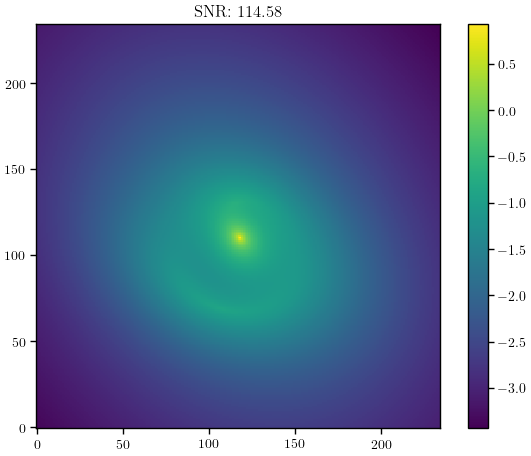

In [8]:
roman = Roman()

lens = random.choice(high_snr_lenses)
band = 'F129'
scene_size = 5  # arcsec
oversample = 5
exposure_time = 146

synthetic_image = SyntheticImage(strong_lens=lens,
                                 instrument=roman,
                                 band=band,
                                 arcsec=scene_size,
                                 oversample=oversample,
                                 verbose=True)

plt.imshow(np.log10(synthetic_image.image))
plt.colorbar()
plt.title(f'SNR: {lens.snr:.2f}')
plt.show()

In [9]:
pandeia_params = pandeia_engine.default_roman_engine_params()
pprint(pandeia_params)

{'background': 'minzodi',
 'background_level': 'medium',
 'calculation': {'effects': {'saturation': True},
                 'noise': {'crs': True,
                           'dark': True,
                           'excess': False,
                           'ffnoise': True,
                           'readnoise': True,
                           'scatter': False}},
 'num_samples': 10000}


In [ ]:
pandeia_params['num_samples'] = int(1e4)
pandeia_params['background_level'] = 'low'

pandeia = Exposure(synthetic_image,
                   exposure_time=exposure_time,
                   engine='pandeia',
                   engine_params=pandeia_params,
                   verbose=True)

100%|██████████| 6201/6201 [01:05<00:00, 94.93it/s] 


Point source conversion complete: placed 6201 point sources
Exposure calculation time with pandeia engine: 0:17:28


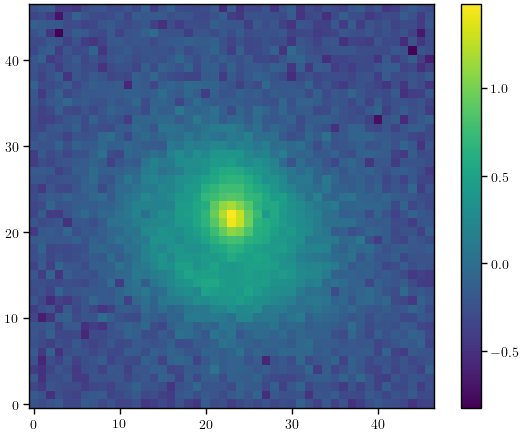

In [11]:
plt.imshow(np.log10(pandeia.exposure))
plt.colorbar()
plt.show()

In [12]:
galsim_params = galsim_engine.default_roman_engine_params()
pprint(galsim_params)

{'dark_noise': True,
 'detector_effects': True,
 'ipc': True,
 'nonlinearity': True,
 'poisson_noise': True,
 'read_noise': True,
 'reciprocity_failure': True,
 'rng': galsim.UniformDeviate(seed='812239652 1970235701 3299693958 ... 876553515 2415570789 899044626'),
 'sky_background': True}


In [ ]:
galsim = Exposure(synthetic_image,
                  exposure_time=exposure_time,
                  engine='galsim',
                  engine_params=galsim_params,
                  verbose=True)

PSF F129 SCA01 (2048, 2048) 5 101 not found in cache test_data
Exposure calculation time with galsim engine: 0:00:32


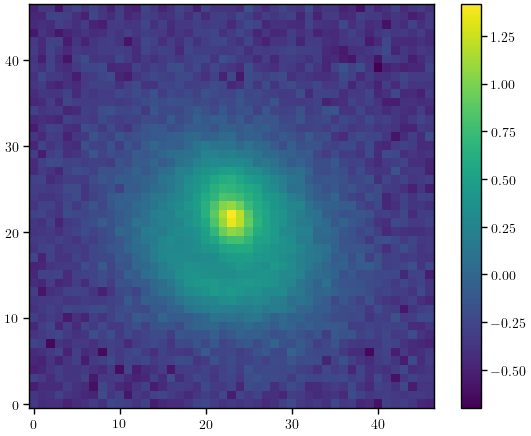

In [14]:
galsim.exposure /= exposure_time

plt.imshow(np.log10(galsim.exposure))
plt.colorbar()
plt.show()

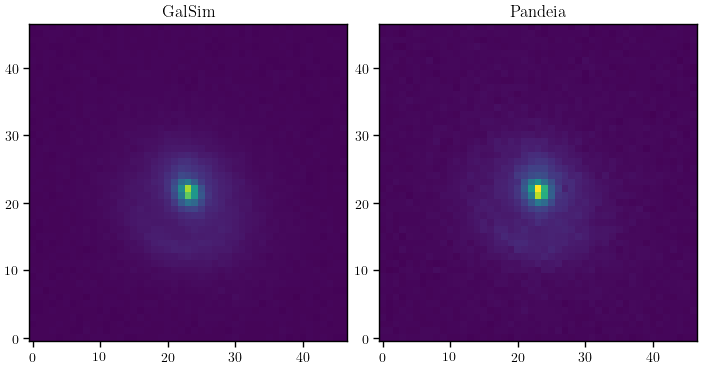

In [15]:
_, ax = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)

vmax = np.max([galsim.exposure, pandeia.exposure])

ax[0].imshow(galsim.exposure, vmin=0, vmax=vmax)
ax[0].set_title('GalSim')

ax[1].imshow(pandeia.exposure, vmin=0, vmax=vmax)
ax[1].set_title('Pandeia')

plt.show()

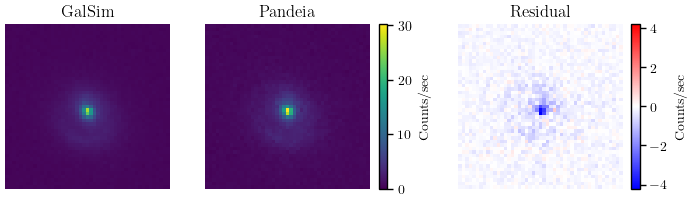

In [16]:
f, ax = plt.subplots(1, 3, figsize=(7, 2), constrained_layout=True)

v = plot_util.get_v([galsim.exposure, pandeia.exposure])

ax[0].imshow(galsim.exposure, vmin=0, vmax=v)
ax[0].set_title('GalSim')
ax[0].axis('off')

axis = ax[1].imshow(pandeia.exposure, vmin=0, vmax=v)
ax[1].set_title('Pandeia')
ax[1].axis('off')

cbar = f.colorbar(axis, ax=ax[1])
cbar.set_label('Counts/sec', rotation=90)

residual = galsim.exposure - pandeia.exposure
v = plot_util.get_v(residual)
# norm = plot_util.get_norm(residual, linear_width=100.)

axis_residual = ax[2].imshow(residual, cmap='bwr', vmin=-v, vmax=v)  # , norm=norm
ax[2].set_title('Residual')
ax[2].axis('off')

cbar_res = f.colorbar(axis_residual, ax=ax[2])
cbar_res.set_label('Counts/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'galsim_pandeia_compare.png'))
plt.show()